# RNN


In [2]:
import os
import sys
import copy
import zipfile
import time
import random
import collections
import numpy as np
from PIL import Image
import pickle
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)
print(np.__version__)
%load_ext autoreload
%autoreload 2

1.13.1
1.24.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recurrent Neural Networks

vanilla RNN cell. the RNN has a certain structure that allows it to accept the previous hidden state the current input, and output an hidden state and an output vector. The RNN cell uses the same weights for all time steps, much like convolution uses the same weights for all the batches in the image.

## Helper functions

In [3]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Vanilla RNN: step forward 

`rnn_step_forward` - forward pass for a single timestep of a vanilla recurrent neural network.

In [4]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None

    next_h = np.tanh((x @ Wx) + (prev_h @ Wh) + b)
    cache = (x,Wx,prev_h,Wh,b)
    return next_h, cache

In [5]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward

In [6]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    (x,Wx,prev_h,Wh,b) = cache
    tan_grad = 1 - (np.tanh(x @ Wx + (prev_h @ Wh) + b) ** 2)
    d_ups = dnext_h * tan_grad
    dx = d_ups @ Wx.T
    dWx = x.T @ d_ups
    dprev_h = d_ups @ Wh.T
    dWh = prev_h.T @ d_ups
    db = d_ups.sum(axis=0)
    return dx, dprev_h, dWx, dWh, db

In [7]:
np.random.seed(1337)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)
out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.8730509825914645e-10
dprev_h error:  1.931634610323001e-08
dWx error:  6.586630396892865e-10
dWh error:  9.131820369191576e-10
db error:  8.569581669830872e-10


# Vanilla RNN: forward 
implement a RNN that process an entire sequence of data.

In [8]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    N,T,D,H=x.shape[0],x.shape[1],x.shape[2],h0.shape[1]
    h=np.zeros((N,T,H))
    cache_ls=[]
    for i in range(T):
        x_current=x[:,i,:]
        if not i:
            h[:,i,:], cache = rnn_step_forward(x_current, h0, Wx, Wh, b)
        else:
            h[:, i, :], cache = rnn_step_forward(x_current, h[:, i-1, :], Wx, Wh, b)
        cache_ls.append(cache)
    return h, cache

In [9]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# Vanilla RNN: backward

In [12]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    T = len(cache)
    dx=[]
    dprev_h_curr=np.zeros((N,H))
    for i in reversed(range(T)):
        dh_curr = dh[:,i,:] + dprev_h_curr
        dx_curr, dprev_h_curr, dWx_curr, dWh_curr, db_curr = rnn_step_backward(dh_curr, cache[i])
        dx.append(dx_curr)
        dprev_h = dprev_h_curr
        if i==T-1:
            dWx = dWx_curr
            dWh = dWh_curr
            db = db_curr
        else:
            dWx+=dWx_curr
            dWh+=dWh_curr
            db+=db_curr
    dx=np.flip(np.swapaxes(np.array(dx), 0, 1),1)
    dh0=dprev_h
    return dx, dh0, dWx, dWh, db

In [13]:
np.random.seed(1337)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

TypeError: unsupported operand type(s) for @: 'numpy.float64' and 'numpy.float64'

##**Question:** 
When using valina RNN on long sequences, what could happen? What causes this to happen?   **(5 Points)**

**Your answer:** When using RNN for long sequences the model could face vanishing or exploding gradient problem, if this happens the training becomes slow or even couldn't train at all. This caused when we input long sequences and therefore when training, at the backward we multiply some of gradients by gradients of another stage multiple time. therefore they vanish (if < 1) or exploding (if > 1)


##**Question:** 
Could this problem be solved by a different model? How does it accomplish this?   **(5 Points)**

**Your answer:** Yes this problem could be solved with LSTM for example. LSTM has long term memory which doesn't have alot of multipications, therefore it couldn't happen.

# Image Captioning in PyTorch 

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexability of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network. We only need to provide proper labels to train the new network we created. For this exercise, you will be provided with pretrained networks for both feature extraction and sentence generation, and you will connect the different components needed to make image captioning work.

First, we define the feature extractor and the recurrent model seperately. The feature extractor takes an image and produces a vector representation of the image features. As those features hold information about the image, we will use that vector as the input for our recurrent model. The RNN will produce the image captioning using an LSTM architecture. 

In [14]:
# unzipping the pretrained models
with zipfile.ZipFile(os.path.join('models', 'pretrained_model.zip'), 'r') as zip_ref:
    zip_ref.extractall('models')

In [15]:
# unzipping vocabulary
with zipfile.ZipFile(os.path.join('data', 'vocab.zip'), 'r') as zip_ref:
    zip_ref.extractall('data')

In [16]:
conv_path = 'models/encoder-5-3000.pkl'
lstm_path = 'models/decoder-5-3000.pkl'
vocab_path   = 'data/vocab.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the following code to check if all the files are in place
print("conv_path ", '✓' if os.path.isfile(conv_path) == True else '✗') 
print("lstm_path ", '✓' if os.path.isfile(lstm_path) == True else '✗') 
print("vocab_path ", '✓' if os.path.isfile(vocab_path) == True else '✗') 

conv_path  ✓
lstm_path  ✓
vocab_path  ✓


## Implementing image captioning model 

use a pretrained model to solve the image captioning task. 

**ConvNet architecture:** resnet152 (without last fc layer) -> fc layer -> BatchNorm1d

**LSTM architecture:** LSTM -> linear -> embed


In [17]:
embed_size   = 256      # dimension of word embedding vectors
hidden_size  = 512      # dimension of lstm hidden states
num_layers   = 1        # number of layers in lstm

In [18]:
class ConvNet(nn.Module):
    def __init__(self, embed_size):
        super(ConvNet, self).__init__()
        self.resnet = models.resnet152(True) # construct an nn.Sequential model without the last resnet152 layer
        # make sure you define each of the None parameters
        self.linear = None
        self.bn = None
    
        for param in self.resnet.parameters():
            param.requires_grad = False
        in_features=self.resnet.fc.in_features
        self.linear = torch.nn.Linear(in_features, embed_size)
        self.resnet.fc=self.linear
        self.bn = torch.nn.BatchNorm1d(embed_size, momentum=0.01)
    
    
    def forward(self, images):
     
        x = images
        x = self.resnet(x)
        x = self.bn(x)
        return x


class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM, self).__init__()
     
        self.max_seg_length = max_seq_length
        self.embed = torch.nn.Embedding(vocab_size,embed_size)
        self.lstm = torch.nn.LSTM(embed_size,hidden_size,num_layers)
        self.linear = torch.nn.Linear(in_features=hidden_size,out_features=vocab_size)
      
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted).unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)        
        return sampled_ids

In [19]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [21]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [22]:
# Build models
conv = ConvNet(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
lstm = LSTM(embed_size, hidden_size, len(vocab), num_layers)
conv = conv.to(device)
lstm = lstm.to(device)

#resnet_saved_dict=torch.load(conv_path)
#resnet_saved_dict_new = {k.replace('resnet.','resnet.layer'):v for k,v in resnet_saved_dict.items()}

# Load the trained model parameters
conv.load_state_dict(torch.load(conv_path),strict=False)
lstm.load_state_dict(torch.load(lstm_path),strict=False)

# Prepare an image
image_path = os.path.join('data', 'pic.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)

/Users/drado/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/drado/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<start> a clock tower with a clock on top of it . <end>


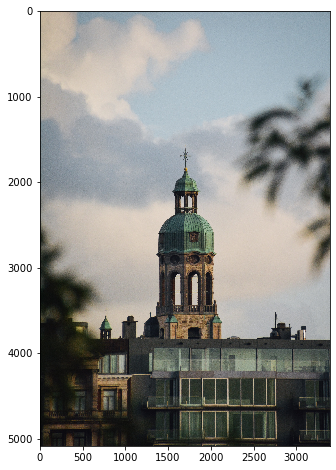

In [23]:
# Generate an caption from the image
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));

<start> a group of people playing with a frisbee in a park . <end>


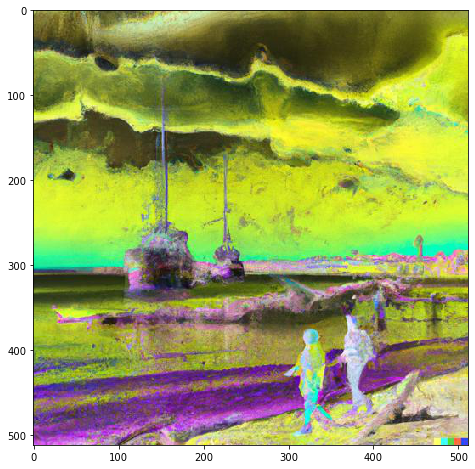

In [126]:
# Prepare an image
image_path = os.path.join('data', 'mypic.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));